In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from keras.layers import Dense
from keras.models import Sequential
import os

In [2]:
df = pd.read_csv('/home/saichaitanya/Chaitanya/CSV files/1000 points per trajectory/May10rd1percent_RLV_data 1000 points.csv',header = None,names = ['h','v','s','omega','gamma','m','theta','Thrust','beta','time'])
input = output =df.values
X = input[:,0:7]
y = output[:,7:9]
# Individual Data
from sklearn import preprocessing
X_norm = preprocessing.minmax_scale(X)
y_norm = preprocessing.minmax_scale(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [3]:
def create_model2(n):
    model = Sequential()
    model.add(Dense(n,input_shape=(7,),kernel_initializer='uniform'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu')) # since tanh has more nonlinearity we add it here, it also gives -ve values so , some layers which are not necessary will lead to 0 in next layer
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(2,kernel_initializer='uniform',activation = 'sigmoid'))
    return model

In [4]:
i = 7;
model = create_model2(2**i)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.mean_squared_error
def lr_sch3(epoch,lr):
    if (epoch>0)& (epoch<60):
      if epoch%15==0: # for every 100 epochs the learning rate varies as metioned. 
        return round(lr*np.exp(-0.45),7)
      else:
        return round(lr,7)
    elif(epoch>60):
        if epoch%5==0:
            return round(lr*0.85,9)
        else:
            return round(lr,9)
    else:
        return round(lr,9)
print("The Number of Hidden units used is: ",2**i)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_sch3,verbose = 1)
bs = 32;
STEPS_PER_EPOCH = X_train.shape[0] / bs
save_period = 5
checkpoint_path = f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/retrained 1percent model having 128 neurons and batchsize 32/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                            save_freq=int(save_period*STEPS_PER_EPOCH))
model.compile(optimizer = opt, loss = loss, metrics = 'accuracy')
iter1 = 150

The Number of Hidden units used is:  128


2022-05-16 18:32:54.175644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-16 18:32:54.175703: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-16 18:32:54.176636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.load_weights(f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/retrained 1percent model having 128 neurons and batchsize 32/cp.ckpt")

In [6]:
model.evaluate(X_test,y_test)

6842/6842 [==============================] - 9s 1ms/step - loss: 5.0180e-05 - accuracy: 0.9954


[5.0180457037640736e-05, 0.9953544735908508]

In [7]:
pred = model.predict(X_norm)

In [8]:
import math
R0 = 6378*1000;
g0=9.81
Cd = 0.5
S_ref =10.75
Isp =300;
I_z = 3346393
l_com = 9.778
t_ref = 32
h0=5000;
v0=325;
s0=850;
## The inputs and outputs which varied have values in decimals 
## rest all have been rounded off to 5-6 digits
omega0= 0.342
theta0= round(-75*math.pi/180,4)
gamma0= round(-75*math.pi/180,4) #
m0= round(26229.667,0) # our values of mass are rounded of when taking data
r0 = h0+6378000
idx = df.loc[(df['h'] == h0) & (df['v'] == v0)]
idx = np.array(idx.index.astype(int))
def trajectory_finding(idx,df,s0):
    # we have 3003 points for getting full trajectory starting from index 0-3002
    for i in range(idx.shape[0]):
        df2= df[idx[0]+3003*i:idx[0]+3003*(i+1)]
        if (df2.s.values[3002]==s0):
            break
        else:
            continue
    return np.array([df2.index[0],df2.index[3002]])
idx_i,idx_f = trajectory_finding(idx,df,s0)


#  Plots checking how the pred vs actual plots vary

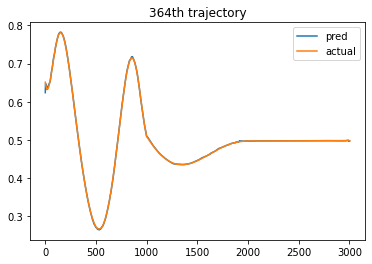

In [9]:
i=1
j = int(idx_i/3003)
no = 0
plt.plot(pred[:,i][0+3003*j:3003*(j+1)])
plt.plot(y_norm[:,i][0+3003*j:3003*(j+1)])
plt.title(f'{j}th trajectory')
plt.legend(['pred','actual'])

Text(0.5, 1.0, '364th trajectory starting 0 to 70 points')

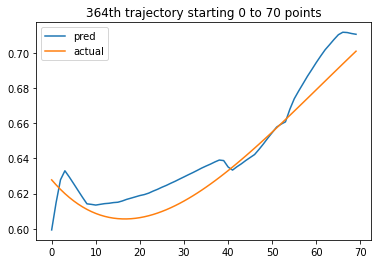

In [10]:
plt.plot(pred[:,i][0+no:70])
plt.plot(y_norm[:,i][0+no:70])
plt.legend(['pred','actual'])
plt.title(f'{j}th trajectory starting {no} to 70 points')

# From this plot we can see our retrained model for 1 percent data is not yet accurate. Lets try reducing the batch size to 16 ->....1 and observe the accuracy

In [13]:
bs = 1;
STEPS_PER_EPOCH = X_train.shape[0] / bs
save_period = 1
checkpoint_path = f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/retrained 1percent model having 128 neurons and batchsize 32 to 1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                            save_freq=int(save_period*STEPS_PER_EPOCH))
model.compile(optimizer = opt, loss = loss, metrics = 'accuracy')
iter2 = 10

In [ ]:
time(model.fit(X_train,y_train,epochs = iter2,batch_size = bs,shuffle = True,use_multiprocessing = True,callbacks=[lr_scheduler,cp_callback],validation_data=(X_val, y_val)))


Epoch 1: LearningRateScheduler setting learning rate to 1.6365e-05.
Epoch 1/10
1960243/1960268 [============================>.] - ETA: 0s - loss: 1.0652e-04 - accuracy: 0.9926
Epoch 1: saving model to /home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/retrained 1percent model having 128 neurons and batchsize 32 to 1/cp.ckpt
1960268/1960268 [==============================] - 4216s 2ms/step - loss: 1.0653e-04 - accuracy: 0.9926 - val_loss: 7.9149e-05 - val_accuracy: 0.9945 - lr: 1.6365e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.64e-05.
Epoch 2/10
1960255/1960268 [============================>.] - ETA: 0s - loss: 1.0624e-04 - accuracy: 0.9927
Epoch 2: saving model to /home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/retrained 1percent model having 128 neurons and batchsize 32 to 1/cp.ckpt
1960268/1960268 [==============================] - 4264s 2ms/step - loss: 1.0624e-04 - accuracy: 0.9927 - val_loss: 5.9606e-05 - val_accuracy: 0.9946 - lr: 1.6400e-05

Epoch 3: LearningRa